# Benchmarking whisper models for speed

### Notes
Sometime the transcription can contain hallucinations / biais: it adds some noise to the transcription, for example it will add "Sous-titrage ST'501" at the end of the transcription, where there is no audio.
See [this issue](https://github.com/openai/whisper/discussions/928) and implement some code to remove this noise.

In [1]:
from faster_whisper import WhisperModel
import matplotlib.pyplot as plt
import time
import datetime
from pydub import AudioSegment
from tqdm.notebook import tqdm
import numpy as np

class WhisperModelWrapper:
    def __init__(self, model_path, model_name):
        self.model_path = model_path
        self.model_name = model_name
        self.model = None

    def load_model(self):
        self.model = WhisperModel(self.model_path, device="cuda", compute_type="float16")

    @staticmethod
    def get_audio_length(audio_path):
        audio = AudioSegment.from_file(audio_path)
        duration = len(audio) / 1000.0
        return duration

    def compute(self, audio_path, debug=False):
        if self.model is None:
            self.load_model()
        start_time = time.time()
        total_duration = self.get_audio_length(audio_path)
        
        with tqdm(total=total_duration, desc=self.model_name, unit="s") as pbar:
            segments, info = self.model.transcribe(audio_path, beam_size=5, language="fr", condition_on_previous_text=False)
            for segment in segments:
                start_time_segment = str(datetime.timedelta(seconds=int(segment.start)))
                end_time_segment = str(datetime.timedelta(seconds=int(segment.end)))
                pbar.n = min(segment.end, total_duration)
                pbar.refresh()
                if debug:
                    print(f"Segment: {start_time_segment} - {end_time_segment} : {segment.text}")
            pbar.n = total_duration
            pbar.refresh()

        end_time = time.time()
        time_taken = end_time - start_time
        return time_taken

def benchmark(models, audio_path: str, debug: bool = False):
    results = []
    for model_path, name in models:
        model_wrapper = WhisperModelWrapper(model_path, name)
        time_taken = model_wrapper.compute(audio_path, debug=debug)
        results.append((name, time_taken))
    return results

def visualize_benchmark(results, audio_path):
    # Using the static method get_audio_length from WhisperModelWrapper
    audio_length_seconds = WhisperModelWrapper.get_audio_length(audio_path)
    
    names = [result[0] for result in results]
    times = [result[1] for result in results]
    
    audio_length = str(datetime.timedelta(seconds=int(audio_length_seconds)))
    title = f"{audio_path} - Length: {audio_length}"
    
    plt.figure(figsize=(10, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, len(names)))
    for i, time in enumerate(times):
        plt.bar(names[i], time, color=colors[i])
        speed_up = audio_length_seconds / time
        processing_time_str = str(datetime.timedelta(seconds=int(time)))
        plt.text(names[i], time, f"{processing_time_str} (x{speed_up:.2f})", ha='center', va='bottom')
    
    plt.xlabel('Model')
    plt.ylabel('Time Taken (seconds)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [2]:
models = [
    ("large-v3", 'whisper-large-v3'),
    ("./models/whisper-large-v3-french-distil-dec2/ctranslate2", 'whisper-large-v3-french-distil-dec2'),
    ("medium", 'whisper-medium'),
]

## 5min benchamrk

whisper-large-v3:   0%|          | 0/348.532 [00:00<?, ?s/s]

whisper-large-v3-french-distil-dec2:   0%|          | 0/348.532 [00:00<?, ?s/s]

whisper-medium:   0%|          | 0/348.532 [00:00<?, ?s/s]

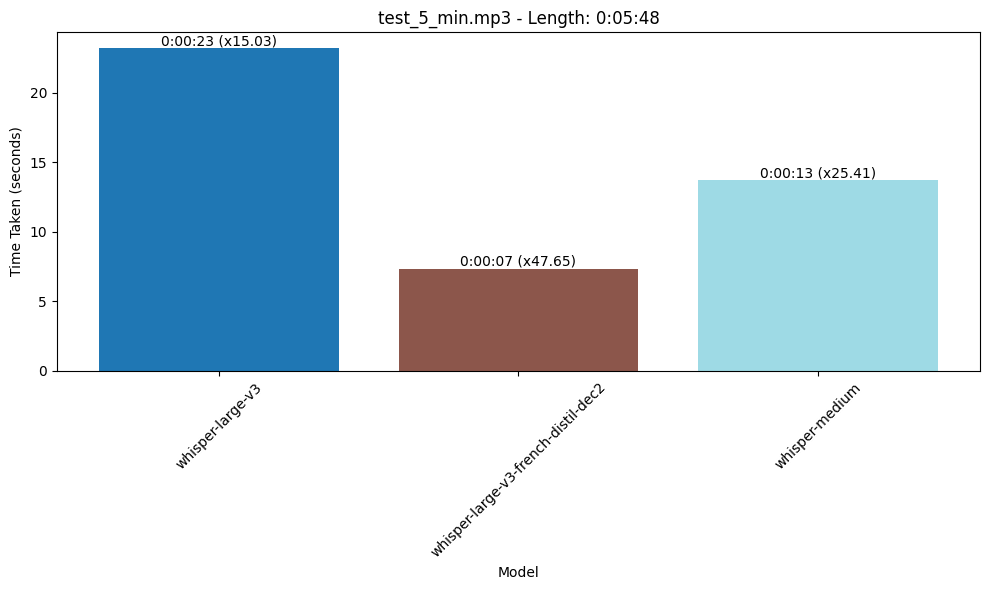

In [10]:
audio_path = "test_5_min.mp3"
results = benchmark(models, audio_path)
visualize_benchmark(results, audio_path)

## 20min benchamrk

whisper-large-v3:   0%|          | 0/1143.258 [00:00<?, ?s/s]

whisper-large-v3-french-distil-dec2:   0%|          | 0/1143.258 [00:00<?, ?s/s]

whisper-medium:   0%|          | 0/1143.258 [00:00<?, ?s/s]

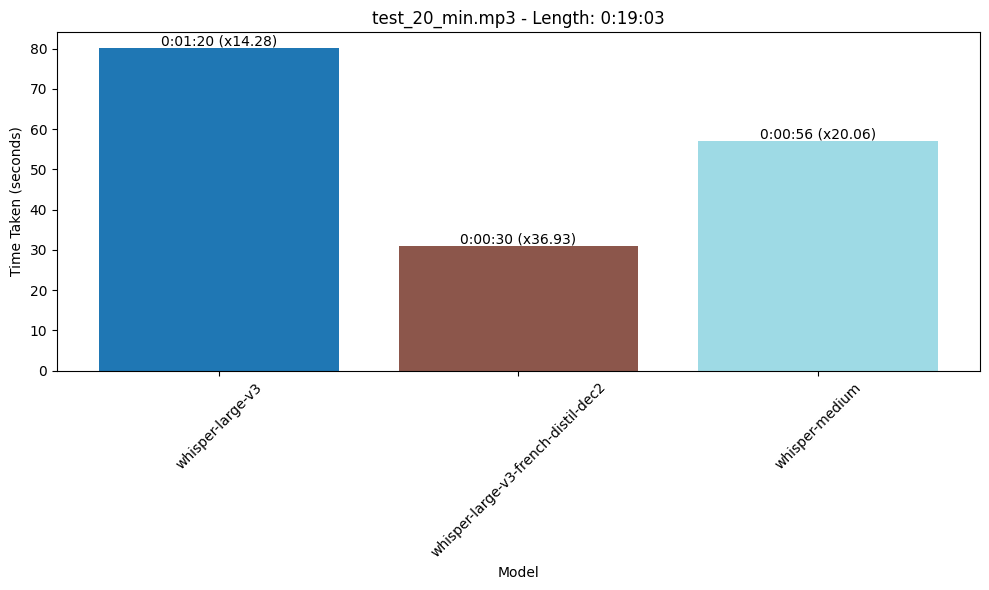

In [3]:
audio_path = "test_20_min.mp3"
results = benchmark(models, audio_path)
visualize_benchmark(results, audio_path)

## Try with audio recording

Recording started...
Recording finished.
Audio saved as test.mp3


whisper-large-v3:   0%|          | 0/10.0 [00:00<?, ?s/s]

Segment: 0:00:00 - 0:00:04 :  I like cats and dogs. J'aime les chiens et les chats.
Segment: 0:00:06 - 0:00:09 :  Hablos español. ¿Cómo está la casa?


whisper-large-v3-french-distil-dec2:   0%|          | 0/10.0 [00:00<?, ?s/s]

Segment: 0:00:00 - 0:00:08 : J'aime catch and dogues. J'aime les chiens et les chats. À ablos espagnol.
Segment: 0:00:08 - 0:00:10 :  Comment est-ce ta à la casa ?


whisper-medium:   0%|          | 0/10.0 [00:00<?, ?s/s]

Segment: 0:00:00 - 0:00:08 :  I like cats and dogs. J'aime les chiens et les chats. Hablos español.
Segment: 0:00:08 - 0:00:10 :  ¿Cómo está la casa?


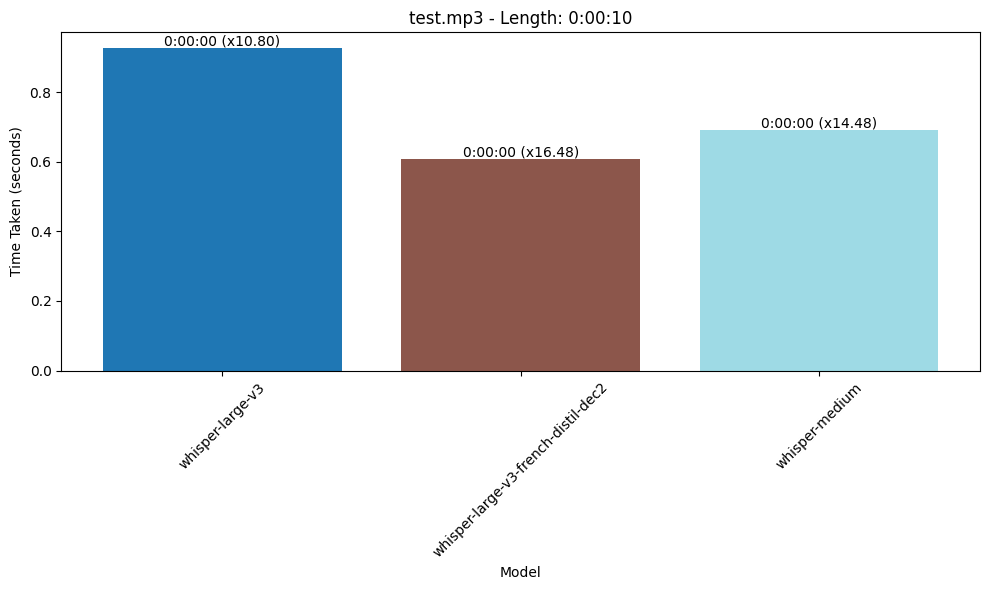

In [7]:

import sounddevice as sd
import numpy as np
from scipy.io.wavfile import write
from pydub import AudioSegment

def record_audio(duration, filename='test.mp3', sample_rate=44100):
    print("Recording started...")
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=2, dtype='int16')
    sd.wait()  # Wait until recording is finished
    print("Recording finished.")
    
    # Save as WAV file first
    write('temp.wav', sample_rate, recording)
    
    # Convert WAV to MP3
    audio = AudioSegment.from_wav('temp.wav')
    audio.export(filename, format="mp3")
    print(f"Audio saved as {filename}")

filename = "test.mp3"
record_audio(duration=10, filename=filename)
results = benchmark(models, filename, debug=True)
visualize_benchmark(results, filename)